In [12]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
from gensim.models import Word2Vec
import os
import pickle

pd.set_option('display.max_columns', None)


# Load the dataset
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
display(pueblos_cmun)
display(user_choices_cmun)

[48067,
 15064,
 15039,
 48062,
 48905,
 33038,
 33005,
 39067,
 31250,
 33078,
 39045,
 39069,
 39007,
 48087,
 48081,
 48060,
 31264,
 33001,
 31239,
 39100,
 48037,
 48007,
 33061,
 20901,
 48086,
 39081,
 48052,
 39066,
 33062,
 33048,
 39057,
 39088,
 39049,
 20003,
 39063,
 48030,
 33052,
 15027,
 39034,
 48915,
 31153,
 39101,
 48912,
 33003,
 15068,
 48008,
 20027,
 39078,
 20016,
 27015,
 39072,
 31082,
 15003,
 39098,
 31259,
 48022,
 48051,
 15040,
 15014,
 33027,
 39021,
 15001,
 27029,
 39026,
 48097,
 39082,
 48092,
 48055,
 27010,
 20002,
 39014,
 39003,
 33058,
 20028,
 31024,
 31022,
 20014,
 48039,
 33067,
 27053,
 15029,
 33050,
 20075,
 48058,
 48019,
 39083,
 20048,
 39004,
 33015,
 27022,
 48065,
 48042,
 48910,
 20006,
 31117,
 48095,
 39022,
 48094,
 20046,
 31226,
 20066,
 1042,
 20010,
 15024,
 39097,
 39086,
 20041,
 39089,
 39055,
 48006,
 39046,
 48025,
 27046,
 48050,
 24116,
 39015,
 33053,
 33072,
 48005,
 20023,
 27007,
 48026,
 20031,
 31087,
 24106,
 

[31249, 22225, 10096, 41056, 43088]

In [13]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0])
display(pueblos_numerical_features)


,enc_scaled__total_population,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score,enc_scaled__female,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__train_distance_score,enc_scaled__airport_distance_score,enc_scaled__age_score
0,1.202982,0.486795,0.318431,0.264530,0.719727,0.821533,1.201708,1.008718,0.651144,0.264530,0.719727,1.219149,-0.337634,0.712179
1,1.963424,1.532639,0.523698,-0.883064,0.719727,0.303967,1.882481,0.600280,1.812144,-0.883064,0.719727,0.568663,-0.337634,0.617432
2,2.352633,1.506274,0.032013,-0.883064,0.719727,-0.989947,2.440904,0.853123,3.287556,-0.883064,0.719727,-1.057550,-0.337634,0.387516
3,2.906747,1.945704,2.230876,1.029592,0.719727,-0.213599,2.933445,1.123794,1.666560,1.029592,0.719727,-0.407065,0.250758,1.257122
4,1.739121,1.022900,0.640146,1.794654,0.719727,2.633013,1.694249,0.807741,1.222469,1.794654,0.719727,1.869634,2.604329,1.750242


,enc_scaled__economy_score,enc_scaled__economy_score_area,enc_scaled__hospital_score_area,enc_scaled__school_score_area,enc_scaled__transport_score,enc_scaled__female,enc_scaled__total_population,enc_scaled__number_of_houses,enc_scaled__connectivity_score,enc_scaled__hospital_distance_score,enc_scaled__school_distance_score,enc_scaled__train_distance_score,enc_scaled__airport_distance_score
0,0.386912,1.185980,1.062733,0.721064,-0.213326,0.482462,0.521190,0.143118,0.224831,1.062733,0.721064,-1.053649,1.424322
1,0.731121,0.865604,0.284170,0.721064,2.110809,1.260643,1.199804,0.767742,0.639890,0.284170,0.721064,1.861526,1.424322
2,-0.397119,0.279576,-0.105112,0.721064,1.077860,0.371063,0.350131,0.148186,-0.021610,-0.105112,0.721064,0.565893,1.424322
3,-0.397119,0.994147,0.284170,0.721064,-0.213326,-0.413576,-0.413611,-0.580331,0.299412,0.284170,0.721064,-1.053649,1.424322
4,6.343633,2.815453,2.619860,0.721064,0.819623,1.977473,1.939453,1.046479,0.952805,2.619860,0.721064,-1.053649,3.771941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665,-0.397119,1.096759,1.062733,0.721064,0.561385,-0.374828,-0.395943,-0.097609,0.125931,1.062733,0.721064,0.565893,0.250512
6666,2.413918,7.126529,-0.494394,0.721064,-0.729801,3.574197,3.709472,2.171563,1.029007,-0.494394,0.721064,-1.053649,0.250512
6667,0.511210,1.842909,0.284170,0.721064,1.077860,0.532511,0.558132,0.915980,0.578280,0.284170,0.721064,1.213709,0.250512
6668,2.413918,3.239257,-0.883675,0.721064,-0.471564,3.398218,3.480590,3.476559,0.552338,-0.883675,0.721064,-0.729741,0.250512


In [14]:
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)

# Add edges based on similarity threshold
threshold = 0.82  # Adjust threshold based on data distribution
# Use batching for edge creation to avoid memory issues
batch_size = 1000
for i in range(len(feature_matrix)):
    for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [5]:
# from sklearn.metrics import silhouette_score
# import numpy as np

# # Test different dimensions
# dimensions_to_test = [16, 24, 32, 48, 64]
# scores = []

# for dim in dimensions_to_test:
#     # Create and train model
#     node2vec = Node2Vec(G, dimensions=dim, walk_length=10, num_walks=20, workers=12)
#     model = node2vec.fit(window=5, min_count=1)
    
#     # Extract embeddings
#     embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    
#     # Evaluate using silhouette score (requires clustering)
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=5, random_state=42)
#     clusters = kmeans.fit_predict(embeddings)
#     score = silhouette_score(embeddings, clusters)
    
#     scores.append((dim, score))
#     print(f"Dimensions: {dim}, Silhouette Score: {score:.4f}")

# # Find best dimension
# best_dim = max(scores, key=lambda x: x[1])[0]
# print(f"Best dimension: {best_dim}")

In [15]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=32, walk_length=15, num_walks=100, workers=2)

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


In [19]:
model = node2vec.fit(
    window=5,    
    min_count=1, 
    batch_words=50,  
    epochs=5,    
    sg=1,            
    hs=0,          
    negative=7        
)

In [20]:
display(similarity_matrix)

array([[1.        , 0.34072578, 0.38877676, ..., 0.41105803, 0.42141495,
        0.61163841],
       [0.34072578, 1.        , 0.79485378, ..., 0.84550873, 0.48147892,
        0.79716152],
       [0.38877676, 0.79485378, 1.        , ..., 0.58255912, 0.21307019,
        0.55658147],
       ...,
       [0.41105803, 0.84550873, 0.58255912, ..., 1.        , 0.59914124,
        0.89977056],
       [0.42141495, 0.48147892, 0.21307019, ..., 0.59914124, 1.        ,
        0.51320621],
       [0.61163841, 0.79716152, 0.55658147, ..., 0.89977056, 0.51320621,
        1.        ]])

In [21]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


In [22]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")


NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 31249: Similarity 0.6478
Village 10096: Similarity 0.6154
Village 3428: Similarity 0.5670
Village 43061: Similarity 0.5659
Village 44251: Similarity 0.5598
Village 3684: Similarity 0.5534
Village 3252: Similarity 0.5504
Village 3766: Similarity 0.5344
Village 4256: Similarity 0.5337
Village 3885: Similarity 0.5329


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_22927/3696273799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")


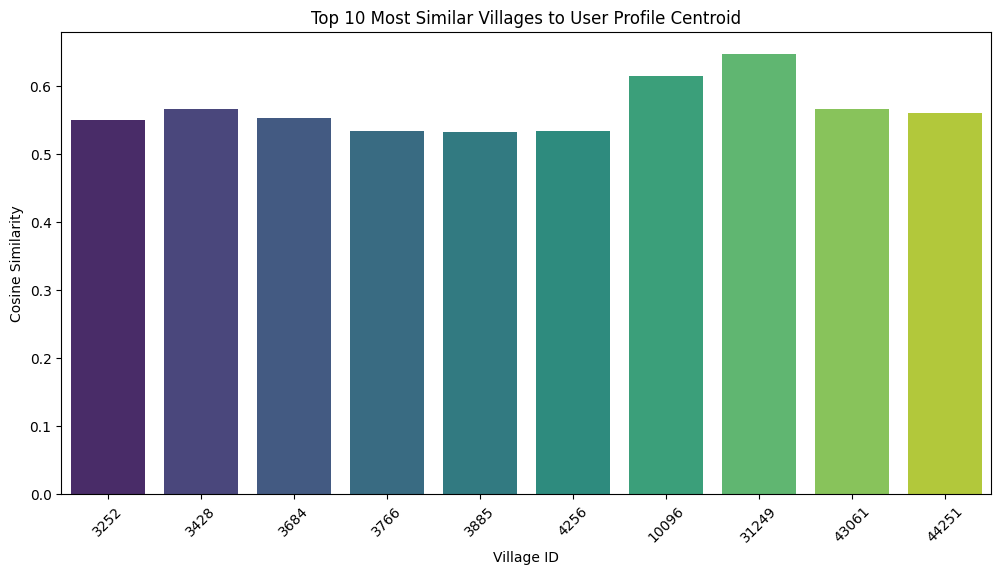

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 similar villages and their scores
top_villages = ranked_villages[:10]
village_ids = [v for v, _ in top_villages]
similarity_scores = [s for _, s in top_villages]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
plt.xlabel("Village ID")
plt.ylabel("Cosine Similarity")
plt.title("Top 10 Most Similar Villages to User Profile Centroid")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# import pandas as pd
# import networkx as nx
# from sklearn.metrics.pairwise import cosine_similarity
# from node2vec import Node2Vec
# from gensim.models import Word2Vec

# # Load the full dataset
# df_pueblos_full = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

# # Load the smaller model
# pre_trained_model = Word2Vec.load("../../models/node2vec_subset.model")

# # Filter encoded features
# df_pueblos_enc_full = df_pueblos_full.filter(regex=r"^enc_", axis=1)
# pueblos_numerical_features_full = df_pueblos_enc_full.loc[:, (df_pueblos_enc_full.nunique() > 2)]

# # Construct the full graph
# G_full = nx.Graph()
# for i, row in pueblos_numerical_features_full.iterrows():
#     cmun = df_pueblos_full.iloc[i, 0]
#     G_full.add_node(cmun, **row.to_dict())

# # Compute pairwise feature similarity (Cosine Similarity)
# feature_matrix_full = pueblos_numerical_features_full
# similarity_matrix_full = cosine_similarity(feature_matrix_full)

# # Add edges based on similarity threshold
# threshold = 0.75

# # Use batching for edge creation to avoid memory issues
# batch_size = 1000
# for i in range(len(feature_matrix_full)):
#     for j in range(i + 1, min(i + batch_size, len(feature_matrix_full))):
#         if similarity_matrix_full[i, j] > threshold:
#             G_full.add_edge(i, j, weight=similarity_matrix_full[i, j])

# # Generate random walks on the full graph
# node2vec_full = Node2Vec(G_full, dimensions=32, walk_length=5, num_walks=10, workers=2)
# walks = node2vec_full.walks  # Get the random walks

# # Initialize a new Word2Vec model with the pre-trained weights
# model_full = Word2Vec(
#     vector_size=pre_trained_model.wv.vector_size,
#     window=10, 
#     min_count=1, 
#     batch_words=100, 
#     epochs=15, 
#     sg=1, 
#     hs=0, 
#     negative=7,
#     workers=2
# )

# # Build vocabulary from the walks
# model_full.build_vocab(walks)

# # Copy weights from pre-trained model for shared vocabulary items
# for word in model_full.wv.index_to_key:
#     if word in pre_trained_model.wv:
#         model_full.wv[word] = pre_trained_model.wv[word]

# # Train the model, starting from the pre-initialized weights
# model_full.train(walks, total_examples=model_full.corpus_count, epochs=model_full.epochs)

# # Save the full model
# model_full.save("../../models/node2vec_full.model")

Generating walks (CPU: 2): 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


In [ ]:
# # 3️⃣ Compute Similarity
# user_selected_villages = user_choices_cmun # Example selected villages
# # Check if all selected villages exist in the model
# valid_villages = [v for v in user_selected_villages if str(v) in model_full.wv]
# if len(valid_villages) < len(user_selected_villages):
#     print(f"Warning: {len(user_selected_villages) - len(valid_villages)} selected villages don't have vector representations")
#     missing = [v for v in user_selected_villages if str(v) not in model_full.wv]
#     print(f"Missing villages: {missing}")

# selected_vectors = [model_full.wv[str(v)] for v in valid_villages]
# centroid_vector = np.mean(selected_vectors, axis=0)

# # Rank all villages based on cosine similarity - only use nodes that exist in the model
# all_village_vectors = {}
# missing_nodes = []
# for v in G.nodes():
#     try:
#         all_village_vectors[v] = model_full.wv[str(v)]
#     except KeyError:
#         missing_nodes.append(v)

# if missing_nodes:
#     print(f"Warning: {len(missing_nodes)} nodes in the graph don't have vector representations")
#     print(f"First 5 missing nodes: {missing_nodes[:5]}")

# similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
# ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# # 4️⃣ Evaluate Ranking Quality
# def ndcg_at_k(ranked_list, ideal_list, k):
#     def dcg(scores):
#         return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
#     ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
#     return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

# ndcg_score = ndcg_at_k(ranked_villages, valid_villages, k=10)
# print(f"NDCG Score: {ndcg_score:.4f}")

# # Display top similar villages
# print("Top 10 Most Similar Villages:")
# for village, score in ranked_villages[:10]:
#     print(f"Village {village}: Similarity {score:.4f}")

First 5 missing nodes: [1223, 2344, 517, 2756, 252]
NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 31249: Similarity 0.6922
Village 10096: Similarity 0.6671
Village 16251: Similarity 0.6419
Village 9338: Similarity 0.5843
Village 41048: Similarity 0.5374
Village 9316: Similarity 0.5271
Village 37110: Similarity 0.5187
Village 43063: Similarity 0.5168
Village 25227: Similarity 0.5144
Village 8127: Similarity 0.5126


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_22444/3696273799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")


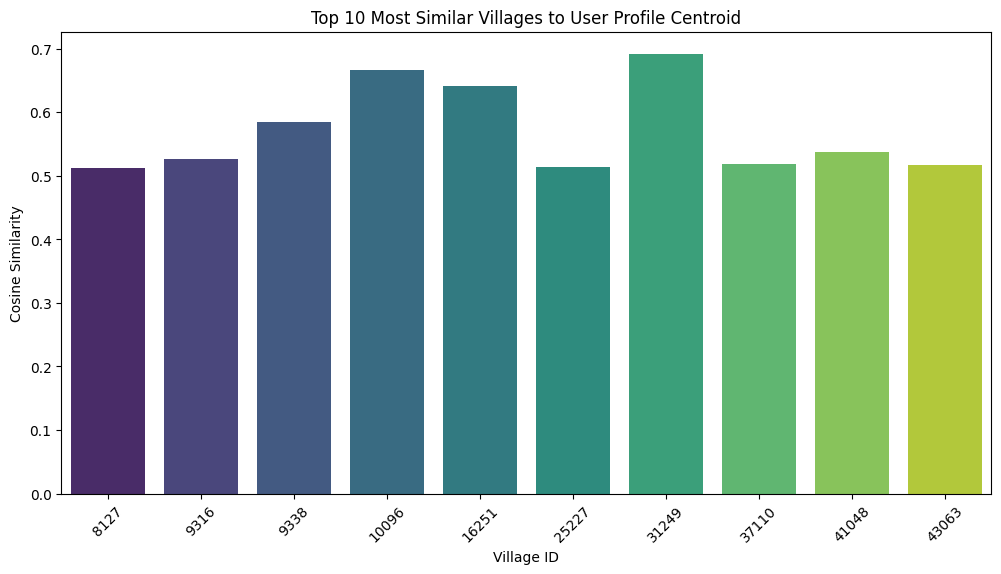

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Extract top 10 similar villages and their scores
# top_villages = ranked_villages[:10]
# village_ids = [v for v, _ in top_villages]
# similarity_scores = [s for _, s in top_villages]

# # Create a bar plot
# plt.figure(figsize=(12, 6))
# sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
# plt.xlabel("Village ID")
# plt.ylabel("Cosine Similarity")
# plt.title("Top 10 Most Similar Villages to User Profile Centroid")
# plt.xticks(rotation=45)
# plt.show()